In [7]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking

# 1. Open exploration

In this file an open exploration has been carried out, in order to explore the given dike model. The open exploration gives an insight in the model's characteristics, outcomes and uncertainties and is used to set up a worst case scenario for further analyses. The following methods has been used:

- Multi scatter plot - ja
- Scenario discovery (PRIM) - ja
  - Feature scoring - ja
  - Dimensional stacking - ja
- Global sensitivity analysis (SOBOL)

In [8]:
# Merge data csv files and print outcomes
# kijk Mart hier!
outcomes_0 = pd.read_csv('data/output_data/outcomes_20000s_0p.csv')
outcomes_random = pd.read_csv('data/output_data/outcomes_20000s_100p_random.csv')
outcomes = outcomes_0.merge(outcomes_random, how='outer')
outcomes.to_csv('data/output_data/outcomes_20000_0p+100p_random.csv')

experiments_0 = pd.read_csv('data/output_data/experiments_20000s_0p.csv')
experiments_random = pd.read_csv('data/output_data/experiments_20000s_100p_random.csv')
experiments= experiments_0.merge(experiments_random, how='outer')
experiments.to_csv('data/output_data/experiments_20000_0p+100p_random.csv')

# Check how this looks by printing
# print(outcomes_complete and experiments_complete)

FileNotFoundError: [Errno 2] No such file or directory: 'data/output_data/outcomes_20000s_0p.csv'

In [ ]:
# Retrieve the outcomes and experiments. The data was generated in the 1_open_exploration_random_scenarios.py file,
# by running the model for 20.000 scenario's.

# OVERBODIG
#experiments = pd.read_csv('data/output_data/experiments_2000s_0p.csv') #Moeten dit niet de merge bestanden zijn?
#outcomes = pd.read_csv('data/output_data/outcomes_2000s_0p.csv')

# Drop column with 'Unnamed'
experiments = experiments.drop(columns='Unnamed: 0')
outcomes = outcomes.drop(columns='Unnamed: 0')

In [ ]:
# Some basic stats could be derived from the outcomes #ZOALS WAT?
outcomes.describe()

As can be seen in the statistics, the values for Dike Investment Costs, RfR Investments Costs & the Evacuation Costs are zero. This is due to the fact that no policies were initiated and do not cost money in this base case. Therefore, from now on, the main focus will be on the outcomes for Expected Annual Damage & Expected number of Deaths. The boxplots for these two outcomes are shown below.

In [ ]:
outcomes.boxplot(column = 'Expected Number of Deaths')
plt.show()

In [ ]:
outcomes.boxplot(column='Expected Annual Damage')
plt.show()

# 1.1 Multiscatter plot

Below the multi scatter plot for the outcomes of the base case is presented. A multi scatter plot plots each scenario with the combination of each outcome on the axes. By plotting each scenario, it could visually be seen whether there exists a correlation between two outcomes, given all scenario's.

In [ ]:
sns.pairplot(outcomes, hue='policy')
plt.show()

The multi scatter plot shows that there seems to exist a positive correlation between the expected number of deaths and the expected actual damage. It implies that the higher the annual damage, the higher the number of deaths will be. All other outcomes logically shows a zero value in the plot, due to the fact that no policies were applied.

# 1.2 Scenario discovery (is dit de goede volgorde? Feature, PRIM, Dimensional stacking?)
## 1.2.1 Feature scoring

Feature scoring can be applied to identify which and to what degree certain features of the model influences the model outcomes. In this open exploration the feature scoring technique is used in order to identify how the uncertainties influence our model outcomes, seen over all scenarios.

In [ ]:
# A list has been created of uncertainties in the model
list_of_uncertainties = ['discount rate 0','discount rate 1','discount rate 2',\
'A.0_ID flood wave shape',
'A.1_Bmax','A.1_pfail','A.1_Brate',\
'A.2_Bmax','A.2_pfail','A.2_Brate',\
'A.3_Bmax','A.3_pfail','A.3_Brate',\
'A.4_Bmax','A.4_pfail','A.4_Brate',\
'A.5_Bmax','A.5_pfail','A.5_Brate',]

uncertainty_experiments = experiments.loc[:,list_of_uncertainties]
uncertainty_experiments

In [ ]:
# Plotting and calculating the feature scoring for each uncertainty and all outcomes
fs = feature_scoring.get_feature_scores_all(uncertainty_experiments, outcomes.drop(columns='policy'))
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

The feature scoring shows that primarily the pfail of dike ring A1 and A3 affects the expected number of death and annual damages. It can be seen that the expected annual damages is mostly influenced by the chance that the dike fails at dike ring A1, while the chance that the dike of A3 fails mainly influences the expected number of deaths.

## 1.2.2 PRIM

Below scenario discovery has been applied, using PRIM. It is chosen to focus at the 10% worst outcomes for both the number of expected deaths and the expected annual damage. This means that only 10% of all scenarios with either the highest number of expected deaths or the highest expected annual damage are included.

The PRIM algorithm was used with the default value for the peeling alfa and a value of 0.8 as threshold. 0.8 was chosen after conducting a small sensitivty analysis, which showed that the use of another threshold did not lead to significantly different results


Wel nog iets toevoegen over keuze van box!!
### 1.2.2.1 Expected Number of Deaths

In [ ]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
x = uncertainty_experiments
y = outcomes['Expected Number of Deaths'] > np.percentile(outcomes['Expected Number of Deaths'],90) #

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
#NOG BEPALEN WELKE BOX WE WILLEN BEKIJKEN!
box1.inspect(40)
box1.inspect(40, style="graph")
box1.show_pairs_scatter(40)
plt.show()

### 1.2.2.2 Expected Annual Damage

In [ ]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)

x = uncertainty_experiments
y = outcomes['Expected Annual Damage'] > np.percentile(outcomes['Expected Annual Damage'],90) #

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
#NOG BEPALEN WELKE BOX WE WILLEN BEKIJKEN!
box1.inspect(0)
box1.inspect(0, style="graph")
box1.show_pairs_scatter(0)
plt.show()

## 1.2.3 Dimensional stacking

The dimensional stacking can be seen as a visual way to again identify which and to what degree uncertainties influence the model outcomes. The result of the dimenstional stacking is a pivot table with bins, showing only the most important uncertainties that affect the models behaviour.

### Expected Number of Deaths

In [ ]:
x = uncertainty_experiments
y = outcomes['Expected Number of Deaths'].values > np.percentile(outcomes['Expected Number of Deaths'],90)
dimensional_stacking.create_pivot_plot(x,y)

plt.show()

Hoe las je deze ook alweer af???

It can be seen that the fail chances of the dikes of dike rings A1 and A3 are identified as the most important uncertainties for the system behaviour of the dike model, regarding the expected number of deaths. Also, the B-max of those dike rings has been analysed as important and influential. It thus appears that the uncertainties of especially dike ring 1 and 2 have high influence to the expected number of deaths.

### Expected Annual Damage

In [ ]:
x = uncertainty_experiments
y = outcomes['Expected Annual Damage'].values > np.percentile(outcomes['Expected Annual Damage'],90)
dimensional_stacking.create_pivot_plot(x,y)

plt.show()

The same conclusion as for the number of expected deaths can be drawn for the expected annual damage; the fail chances of the dikes in dike rings A1 and A3 have high influence to the annual damage. It can also be seen that the discount rates are of high importance. This makes sense due to the fact that the exoected annual damage is being monitized over time by the discount rate; the value of the discount rate therefore influences the magnitude of the expected costs. This is reflected in the results.

# 1.3 Global sensitivity analysis (SOBOL)


In [9]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench import Samplers
from ema_workbench.em_framework import get_SALib_problem
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
from SALib.analyze.sobol import analyze

In [25]:
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [26]:
problem = get_SALib_problem(dike_model.uncertainties)
problem

{'num_vars': 19,
 'names': ['A.0_ID flood wave shape',
  'A.1_Bmax',
  'A.1_Brate',
  'A.1_pfail',
  'A.2_Bmax',
  'A.2_Brate',
  'A.2_pfail',
  'A.3_Bmax',
  'A.3_Brate',
  'A.3_pfail',
  'A.4_Bmax',
  'A.4_Brate',
  'A.4_pfail',
  'A.5_Bmax',
  'A.5_Brate',
  'A.5_pfail',
  'discount rate 0',
  'discount rate 1',
  'discount rate 2'],
 'bounds': [(0, 133),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (0, 4),
  (0, 4),
  (0, 4)]}

In [27]:
experiments = pd.read_csv('data/output_data/sobol_open_exploration_1000s_experiments.csv')
results = pd.read_csv('data/output_data/sobol_open_exploration_1000s_results.csv')

print(f"Shape of data: {experiments.shape[0]} rows, {experiments.shape[1]} columns.")
experiments.head(10)

Shape of data: 400 rows, 54 columns.


,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,0,30,111.986022,1.0,0.340239,195.384165,1.0,0.217241,309.646110,1.0,...,0,0,0,0,0,0,0,0,policy 0,dikesnet
1,1,35,111.986022,1.0,0.340239,195.384165,1.0,0.217241,309.646110,1.0,...,0,0,0,0,0,0,0,1,policy 0,dikesnet
2,2,30,218.549238,1.0,0.340239,195.384165,1.0,0.217241,309.646110,1.0,...,0,0,0,0,0,0,0,2,policy 0,dikesnet
3,3,30,111.986022,1.0,0.340239,195.384165,1.0,0.217241,309.646110,1.0,...,0,0,0,0,0,0,0,3,policy 0,dikesnet
4,4,30,111.986022,1.0,0.919730,195.384165,1.0,0.217241,309.646110,1.0,...,0,0,0,0,0,0,0,4,policy 0,dikesnet
5,5,30,111.986022,1.0,0.340239,108.532245,1.0,0.217241,309.646110,1.0,...,0,0,0,0,0,0,0,5,policy 0,dikesnet
6,6,30,111.986022,1.0,0.340239,195.384165,10.0,0.217241,309.646110,1.0,...,0,0,0,0,0,0,0,6,policy 0,dikesnet
7,7,30,111.986022,1.0,0.340239,195.384165,1.0,0.522370,309.646110,1.0,...,0,0,0,0,0,0,0,7,policy 0,dikesnet
8,8,30,111.986022,1.0,0.340239,195.384165,1.0,0.217241,39.607892,1.0,...,0,0,0,0,0,0,0,8,policy 0,dikesnet
9,9,30,111.986022,1.0,0.340239,195.384165,1.0,0.217241,309.646110,10.0,...,0,0,0,0,0,0,0,9,policy 0,dikesnet


In [17]:
print(f"Shape of data: {results.shape[0]} rows, {results.shape[1]} columns.")
results.head(10)

Shape of data: 3600 rows, 6 columns.


,Unnamed: 0,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354
1,1,9.662522e+07,2.272627e+08,30700000.0,1568.221124,0.008212
2,2,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354
3,3,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354
4,4,0.000000e+00,2.272627e+08,30700000.0,0.000000,0.000000
5,5,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354
6,6,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354
7,7,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354
8,8,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354
9,9,9.804904e+07,2.272627e+08,30700000.0,1624.073114,0.008354


In [32]:
EAD_final_sobol = results['Expected Annual Damage']
EAD_mean_sobol = np.mean(results['Expected Annual Damage'])
EAD_std_sobol = np.std(results['Expected Annual Damage'])

Si = analyze(problem, results.loc[logical,'Expected Annual Damage'].values, calc_second_order=True, print_to_console=True)

                                   ST       ST_conf
A.0_ID flood wave shape  2.505441e-03  2.374448e-03
A.1_Bmax                 6.108284e-03  9.920288e-03
A.1_Brate                5.816498e-15  1.597755e-14
A.1_pfail                1.481816e+00  6.882969e-01
A.2_Bmax                 4.716988e-05  8.781634e-05
A.2_Brate                5.070511e-09  9.337625e-09
A.2_pfail                9.587834e-02  2.477894e-01
A.3_Bmax                 2.046994e-06  3.019690e-06
A.3_Brate                8.619017e-06  1.422587e-05
A.3_pfail                4.751749e-01  6.849315e-01
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                5.831495e-04  7.898931e-04
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                4.374886e-02  9.024275e-02
discount rate 0          3.677646e-02  3.723364e-02
discount rate 1          7.104451e-02  1.039879e-01
discount rat

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

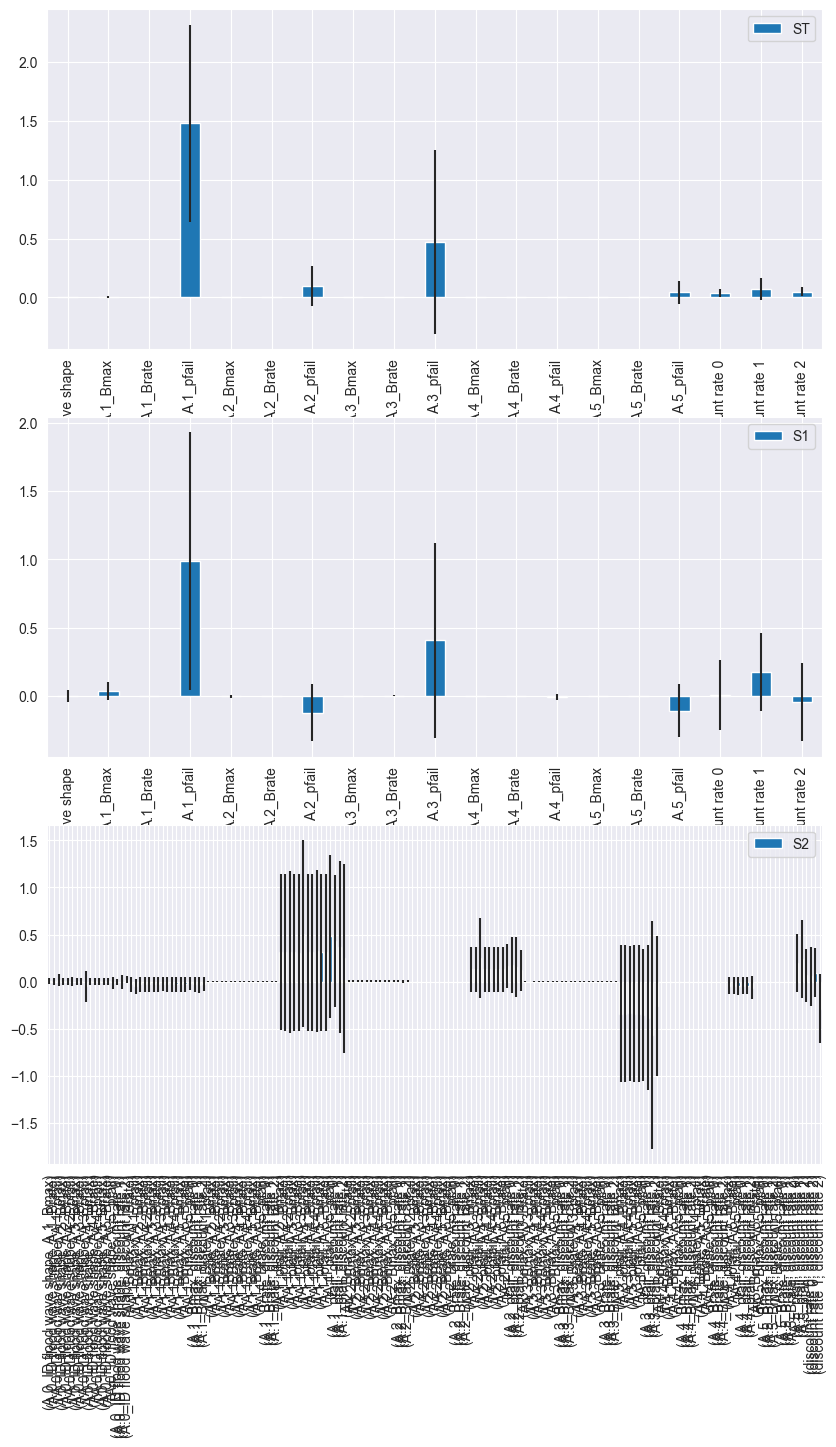

In [31]:
sobol_results = {}

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = results.loc[logical,'Expected Annual Damage'].values
    indices = analyze(problem, y)
    sobol_results[policy] = indices

fig, axes = plt.subplots(3,1)
fig.set_size_inches(10, 15)
indices.plot(ax=axes)

### Info over analyseren SOBOL
The Sobol method is a global sensitivity analysis technique that allows you to assess the relative importance of
input variables (uncertainties) in influencing the output of a model. While you have already selected 9 policies
of interest, the Sobol' analysis can provide valuable insights into the uncertainty and variability associated
with these policies.

Here's why the uncertainty analysis using the Sobol method can still be useful:

#### Identifying influential factors:
The Sobol' method quantifies the contribution of each input variable to the output variability. By assessing the sensitivity indices, you can identify which input variables have the most significant impact on the output. This information can help you focus your efforts on the most influential factors and prioritize them in your decision-making process.
##### A1_pfail, A2_pfail and A3_pfail are influential factors
#### Ranking policies:
While you have selected 9 policies, the Sobol' analysis can help rank these policies based on their performance under different input conditions. It provides insights into how sensitive each policy is to changes in the input variables. By understanding the relative performance and robustness of the policies across different scenarios, you can make informed decisions about their implementation.
#### Trade-off analysis:
The Sobol' analysis can help you understand the trade-offs between different objectives and input variables. By assessing the sensitivity indices, you can identify potential interactions and dependencies between input variables and assess the implications for your chosen policies. This can aid in understanding the trade-offs involved and making more informed decisions that consider the uncertainties associated with each policy.
#### Robustness assessment:
The Sobol' analysis allows you to assess the robustness of your policies by examining their performance across different input variations. It helps you understand how sensitive your policies are to uncertainties and variations in the input variables. Robust policies exhibit consistent performance even under different scenarios, providing confidence in their effectiveness.
In summary, while you have already selected specific policies of interest, the Sobol' analysis provides valuable insights into the uncertainty and sensitivity of the input variables associated with these policies. It helps you understand the relative importance of different factors, rank the policies, analyze trade-offs, and assess their robustness. These insights can enhance your decision-making process and help you make more informed choices regarding the implementation of the selected policies.

## Conclusion on open exploration

BLABLABLB